In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

## Excersises

### 9: PCA on MNIST data set

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

split = 60000
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
X_train.shape, y_test.shape

((60000, 784), (10000,))

In [5]:
from sklearn.ensemble import RandomForestClassifier
from time import time

In [6]:
rf_clf = RandomForestClassifier(
    n_estimators=250,
    random_state=42)

start = time()
rf_clf.fit(X_train, y_train)
end = time()
full_train_acc = rf_clf.score(X_train, y_train)
full_test_acc = rf_clf.score(X_test, y_test)
print('rf_clf w/o dimensionality reduction takes {}s'.format(end-start))
print('with a train and test accuracies of {} and {}, respectively'.format(full_train_acc, full_test_acc))

rf_clf w/o dimensionality reduction takes 229.208477973938s
with a train and test accuracies of 1.0 and 0.9711, respectively


(-0.5, 27.5, 27.5, -0.5)

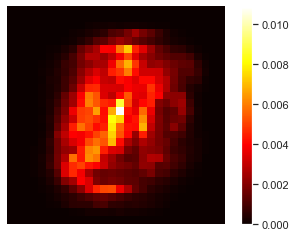

In [9]:
import matplotlib as mpl
plt.imshow(rf_clf.feature_importances_.reshape(28, 28),
          cmap=mpl.cm.hot, interpolation='nearest')
plt.colorbar()
plt.axis('off')

As can be seen from the above random forest's feature importance heatmap, not all
pixels are important--pixels at the center are more important and than the pixels
at the edges. PCA can be used to select important features and throw away the rest.

In [10]:
from sklearn.decomposition import PCA

start = time()
pca = PCA(0.95).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
end = time()
print('PCA run time is: {}s'.format(end-start))

PCA run time is: 5.687533378601074s


In [11]:
rf_clf_pca = RandomForestClassifier(
    n_estimators=250,
    random_state=42)

start = time()
rf_clf_pca.fit(X_train_pca, y_train)
end = time()

pca_train_acc = rf_clf_pca.score(X_train_pca, y_train)
pca_test_acc = rf_clf_pca.score(X_test_pca, y_test)
print('rf_clf with dimensionality reduction takes {}s'.format(end-start))
print('with a train and test accuracies of {} and {}, respectively'.format(pca_train_acc, pca_test_acc))

rf_clf with dimensionality reduction takes 241.3709626197815s
with a train and test accuracies of 1.0 and 0.9514, respectively


In [12]:
# dimension reduction
X_train.shape, X_train_pca.shape

((60000, 784), (60000, 154))

In [14]:
# speedup
print('The speedup is: {:.2f}s'.format((241.37 + 5.68) / 229.21))

The speedup is: 1.08s


Uh, oh!!! run time has actually increased with dimension redcution.

In [15]:
# pereformance comparision
pca_test_acc / full_test_acc

0.9797137267016786

Slight reduction in test set accuracy!!

(-0.5, 27.5, 27.5, -0.5)

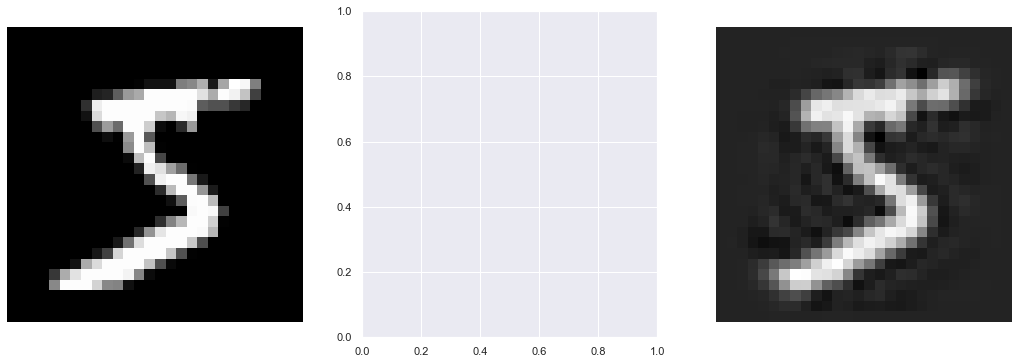

In [25]:
# lets look at origianl and reduced images
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sample = X_train[0].reshape(28, 28)
ax[0].imshow(sample, cmap='gray')
ax[0].axis('off')

# X_train_pca[0] is a linear combination of all the 784 pixels, so looking at it
# will be garbage. We need to look at the inverse_trainsform
# pca_sample = X_train_pca[0].reshape(12, 12)
# ax[1].imshow(pca_sample, cmap='gray')
# ax[1].axis('off')

inv_sample = pca.inverse_transform(X_train_pca[0]).reshape(28, 28)
ax[2].imshow(inv_sample, cmap='gray')
ax[2].axis('off')

### 10: tSNE on MNIST data set

In [26]:
from sklearn.manifold import TSNE

In [27]:
tsne = TSNE(n_components=2, random_state=42)
t0 = time()
X_2d = tsne.fit_transform(X)
t1 = time()
print('tSNE on MNIST run in {:.2f}s'.format(t1-t0))

tSNE on MNIST run in 11261.50s


In [28]:
11261 / 60

187.68333333333334

<AxesSubplot:>

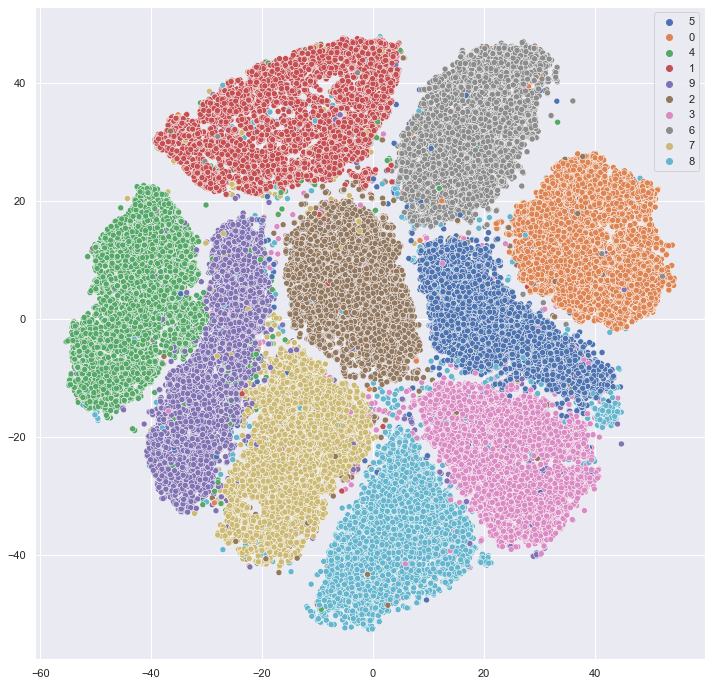

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y, alpha=1.0, ax=ax)

In [33]:
# accuracy with tsne reduced data set

split = 60000
X_train_2d, X_test_2d, y_train_2d, y_test_2d = X_2d[:split], X_2d[split:], y[:split], y[split:]
print(X_train_2d.shape, y_test_2d.shape)

rf_clf_tsne = RandomForestClassifier(
    n_estimators=250,
    random_state=42)

start = time()
rf_clf_tsne.fit(X_train_2d, y_train_2d)
end = time()

tsne_train_acc = rf_clf_tsne.score(X_train_2d, y_train_2d)
tsne_test_acc = rf_clf_tsne.score(X_test_2d, y_test_2d)
print('rf_clf with dimensionality reduction takes {}s'.format(end-start))
print('with a train and test accuracies of {} and {}, respectively'.format(tsne_train_acc, tsne_test_acc))

(60000, 2) (10000,)
rf_clf with dimensionality reduction takes 49.361271381378174s
with a train and test accuracies of 1.0 and 0.9718, respectively


In [37]:
# let's save the trained tsne model
import joblib
filename = 'joblib_tsne_model.sav'
joblib.dump(tsne, filename)

# let's look at accuracy with the saved model
loaded_tsne = joblib.load(filename)

In [39]:
loaded_tsne.fit_transform(X_train[:2])

array([[  164.86682,  1814.1647 ],
       [ -164.8667 , -1814.1644 ]], dtype=float32)

In [40]:
tsne.fit_transform(X_train[:2])

array([[  164.86682,  1814.1647 ],
       [ -164.8667 , -1814.1644 ]], dtype=float32)

In [ ]:
# X_2d_loaded = loaded_tsne.fit_transform(X)

# split = 60000
# X_train_2d, X_test_2d, y_train_2d, y_test_2d = X_2d_loaded[:split], X_2d_loaded[split:], y[:split], y[split:]
# print(X_train_2d.shape, y_test_2d.shape)

# rf_clf_tsne = RandomForestClassifier(
#     n_estimators=250,
#     random_state=42)

# start = time()
# rf_clf_tsne.fit(X_train_2d, y_train_2d)
# end = time()

# tsne_train_acc = rf_clf_tsne.score(X_train_2d, y_train_2d)
# tsne_test_acc = rf_clf_tsne.score(X_test_2d, y_test_2d)
# print('rf_clf with dimensionality reduction takes {}s'.format(end-start))
# print('with a train and test accuracies of {} and {}, respectively'.format(tsne_train_acc, tsne_test_acc))